# Spectrum analysis

```{note}
- [ ] Clean up
- [ ] Fix missing figures
- [ ] Consider visualization and descriptors
```


For the analysis of obtained spectra we will focus on the carbon X-ray absorption spectrum of vinylfluoride. Some analysis on the water X-ray emission spectrum will also be included, but as XES is generally easier to analyse (fewer states, unoccupied state of relatively different energies, etc), focus will be on XAS.

Vinulfluride (C$_2$H$_3$F) is a singly-substituted ethene derivate, which possess large shifts in features for the -CHF site, due to interaction with the very electronegative fluorine. This *chemical shift* is significant and a strong indicator of the local chemical environment. This can be seen in the [experimental spectra] of ethene, vinylfluoride, and 1,1-difluoroethene:


```{figure} ../img/xray/expt_ethene.svg
---
name: /expt_ethene
---
Carbon X-ray absorption spectra of ethene and two substituted derivates. Marking position (and number of contributing carbon sites) of two $1s \rightarrow \pi^{\ast}$ transitions.
```

The position (and number of) $\pi^{\ast}$-resonances are labelled, and we see that a single substitution yield a shift of about 2 eV, and double susbtitution (at the same site) of about 4 eV.

Calculating the vinylfluoride spectrum using CVS-ADC(2)-x:

In [6]:
# loading modules etc

# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

# Lorentzian broadening function
# called with [energies, intensities, start energy, end energy, energy step, broadening]
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

In [3]:
vinyl_xyz = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""

# Construct structure and basis objects
struct  = gator.get_molecule(vinyl_xyz)
basis   = gator.get_molecular_basis(struct,'6-31G')

# Perform SCF calculation
scf_gs = gator.run_scf(struct,basis)

# Calculate the 10 lowest eigenstates with CVS restriction to MOs #1-#3 (fluorine and carbon 1s)
adc_xas = gator.run_adc(struct,basis,scf_gs,method='cvs-adc2x',singlets=10,core_orbitals=[1,2,3])

SCF converged in 7 iterations.
Total Energy: -176.8261179602 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 10                                                          
                               CVS-ADC, Core Orbital Space  : 1 2 3                                                       
                               Convergence threshold        : 1.0e-06                                                     
                                                                           

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    20        0.8829  679ms  [10.90469033 11.01274771 11.12186863 11.13574568 11.15427194 11.22366087
 11.2857491 ]
  2    40       0.10942   1.4s  [10.57182274 10.67941657 10.72935934 10.75067853 10.81315143 10.81361485
 10.84327123]
  3    60     0.0061127   1.9s  [10.55781863 10.63999235 10.70185702 10.72113055 10.76319341 10.78079701
 10.81308683]
  4    80    0.00093309   2.1s  [10.55663466 10.63712206 10.69959324 10.71942116 10.76026737 10.77786443
 10.81039384]
  5   100     0.0001655   2.6s  [10.55654765 10.63677648 10.69916368 10.71927018 10.75988036 10.77734383
 10.81003668]
=== Restart ===
  6    40     2.647e-05   2.1s  [10.55654333 10.63675296 10.69912625 10.71925908 10.75984683 10.77729435
 10.81000543]
  7    60    7.3013e-06   2.0s  [10.55654286 10.63674998 10.69911822 10.71925747 10.75983942 10.77728362
 10.80999969]
  8    80    1.4836e-06   2.4s  [10.55654283 10.63674965 10.

And with CPP-DFT (with the B3LYP functional):

In [4]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(vinyl_xyz)
basis    = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)

# Define spectrum region to be resolved
freqs = np.arange(272.0,285.0,0.25)/au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.4/au2ev},method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

The resulting spectra are shown below, and look quite similar (although with a large difference in absolute energy):

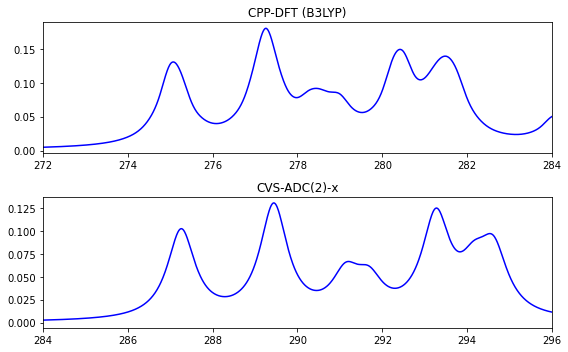

In [8]:
plt.figure(figsize=(8,5))
# CPP-DFT results
plt.subplot(211); plt.title('CPP-DFT (B3LYP)')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'b')
plt.xlim(272,284)

# CVS-ADC(2)-x results
plt.subplot(212); plt.title('CVS-ADC(2)-x')
x,y = au2ev*adc_xas.excitation_energy, adc_xas.oscillator_strength
xi,yi = lorentzian(x,y,280,300,0.01,0.8); plt.plot(xi,yi,'b')
plt.xlim(284,296)
plt.tight_layout(); plt.show()

## Amplitudes

For eigenstates we can study the amplitudes of the eigenvectors to see the contributions in the different excited states. For CPP, a similar analysis on response vectors can be conducted, but this might be made more difficult if th density of states is high and the mixing of cointributions to the response at investigated frequencies is thus significant.

Fro the ADC calculations there is a function `state.describe_amplitudes`, which print the amplitudes using one of three formats, controlled by `index_format`. The amplitudes are printed when above a `tolerance` threshold, and splitting the returning string according to `state` and printing the first two states, we get:

In [21]:
print('From \'hf\' format, which yield MO number:')
des_amp    = adc_xas.describe_amplitudes(tolerance=0.1,index_format='hf')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])
print()

print('\nFirst transition from \'adcc\' format, with indexing as used in adcc:')
des_amp    = adc_xas.describe_amplitudes(tolerance=0.1,index_format='adcc')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print()


print('\nFirst transition from \'homolumo\' format, which using HOMO/LUMO/HOCO format:')
des_amp    = adc_xas.describe_amplitudes(tolerance=0.1,index_format='homolumo')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])

From 'hf' format, which yield MO number:
+---------------------------------------+
| State   1 ,      10.63675 au          |
+---------------------------------------+
|   1     ->  12      a ->a      +0.601 |
|   1     ->  22      a ->a      -0.105 |
|  11   1 ->  12  12  ab->ab     -0.149 |
+---------------------------------------+
| State   2 ,      10.69912 au          |
+---------------------------------------+
|   2     ->  13      a ->a        -0.5 |
|   2     ->  15      a ->a      +0.273 |
|   2     ->  14      a ->a       -0.22 |


First transition from 'adcc' format, with indexing as used in adcc:
+-------------------------------------------------------+
| State   1 ,      10.63675 au,      289.4407 eV        |
+-------------------------------------------------------+
| (o2  1)         -> (v1  0)          a ->a      +0.601 |
| (o2  1)         -> (v1 10)          a ->a      -0.105 |
| (o1  8) (o2  1) -> (v1  0) (v1  0)  ab->ab     -0.149 |


First transition from 'homolumo' fo

From this, it is clear that the two first transitions originates in two different MOs, which corresponds to the -CH$_2$ and -CHF atoms, respectively. The transitions are dominated by single-excitations to the LUMO and LUMO+1, with largest relaxation contributions coming from the HOMO.


## Decomposition of spectra

For a more visual illustration, we can plot the spectra as decomposed according to atomic contributions and polarization of incoming radiation. 

### Atomic contributions

Decomposing according to atomic contributions provides information on which core orbitals that contribute to which features. For vinylfluoride, this can be done by performing CVS calculations with tailored CVS spaces for each carbon site:

In [22]:
struct  = gator.get_molecule(vinyl)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)
adc_chf = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=[2])
adc_ch2 = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=[3])

SCF converged in 7 iterations.
Total Energy: -176.8261179602 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 6                                                           
                               CVS-ADC, Core Orbital Space  : 2                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                           

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    12       0.83779  363ms  [10.95566726 11.09723173 11.22363262 11.38716475 11.45152996 11.46601874]
  2    24        0.2046  654ms  [10.65380288 10.80467648 10.83594988 10.92569049 11.03253872 11.14745754]
  3    36      0.010306  769ms  [10.63808994 10.78045883 10.81247902 10.84957006 10.93904758 11.01133284]
  4    48     0.0013397  989ms  [10.63691445 10.77791559 10.81035773 10.84602802 10.93142281 11.00480161]
  5    60     0.0001776   1.1s  [10.63683717 10.77744923 10.81011882 10.8455034  10.93044828 11.00389063]
=== Restart ===
  6    24    5.7686e-05  920ms  [10.63683012 10.7774054  10.81009624 10.84544999 10.93033759 11.00374539]
  7    36    3.3654e-05  782ms  [10.63682842 10.7773967  10.81009167 10.84543763 10.93029998 11.00366411]
  8    48    1.3715e-05   1.0s  [10.63682822 10.7773952  10.81009101 10.84543576 10.9302912  11.00363115]
  9    60    3.1896e-06   1.2s  [10.6368282  

From which the spectra can be decomposed:

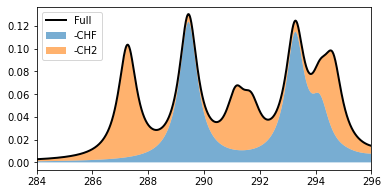

In [23]:
plt.figure(figsize=(6,3))

# Spectrum from -CHF 
x1,y1 = au2ev*adc_chf.excitation_energy, adc_chf.oscillator_strength
x1i,y1i = lorentzian(x1,y1,280,300,0.01,0.8)

# Spectrum from -CH2
x2,y2 = au2ev*adc_ch2.excitation_energy, adc_ch2.oscillator_strength
x2i,y2i = lorentzian(x2,y2,280,300,0.01,0.8)

# Plotting line spectra for full, area spectra for contributions
plt.plot(x2i,y1i+y2i,'k-',linewidth=2.0)
plt.fill_between(x2i, 0, y1i,alpha=0.6)
plt.fill_between(x2i, y1i, y1i+y2i,alpha=0.6)

plt.legend(('Full','-CHF','-CH2'),loc='upper left')
plt.xlim(284,296)
plt.show()

This manner of decomposing the atomic contributions should be taken with some care, as it involves explicit calculation of all atomic sites, which:

1. Requires a larger number of calculations, and care should be taken so that a region in which some states (e.g. for -CHF) are converged into, but not other (e.g. -CH$_2$).

2. Does not strictly fit with the CVS philosophy, which uses the large separation in energy and spatial extend as a basis for separation. Energy separation can now be rather small, and for some systems degeneracies and near-degeneracies may lead to delocalized core orbitals. If so, all delocalized sites must be included in the same CVS space.

Nevertheless, the lower computational cost per calculation of doing this decomposition may make it worth it.

Alternatively, using the full space eigenvectors, we can perform a decomposition as...

```{note}
Do full space eigenvector decomposition and compare to above.

- Either learn how eigenstates are constructed, or just split and divide describe_amplitude results.
```

Performing the same analysis with CPP-DFT, we decompose the solution vectors:

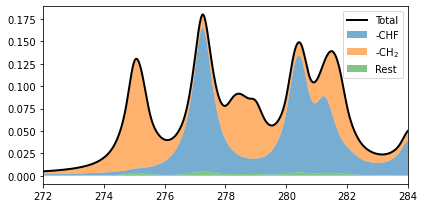

In [24]:
# Number of occupied and unoccupied (alpha) MOs
nocc  = molecule.number_of_alpha_electrons()
nvirt = scf_drv.mol_orbs.number_mos() - nocc

# Extract solution vectors
solution_vecs = cpp_prop.get_property('solutions')
x_solution,y_solution,z_solution = [],[],[]
for w in freqs:
    x_solution.append(solution_vecs[('x',w)])
    y_solution.append(solution_vecs[('y',w)])
    z_solution.append(solution_vecs[('z',w)])
x_solution,y_solution,z_solution = np.array(x_solution),np.array(y_solution),np.array(z_solution)

# Extract polarization-resolved response
sX,sY,sZ = [],[],[]
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    sX.append(4.0/3.0 * np.pi * w * axx / 137.035999)
    sY.append(4.0/3.0 * np.pi * w * ayy / 137.035999)
    sZ.append(4.0/3.0 * np.pi * w * azz / 137.035999)

# Create empty object of dimension nocc (to add spectrum for each occupied)
spec_comp = []
for occ in np.arange(0,nocc): spec_comp.append([])
    
# Appending spec_comp object with decomposed response
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sX[i]+comp_Y*sY[i]+comp_Z*sZ[i]))

# Extract contribution of two carbon atoms
cont_chf  = np.array(spec_comp[1])
cont_ch2  = np.array(spec_comp[2])
cont_full = sigma

plt.figure(figsize=(6,3))
# Create splines spectra for each component
x     = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
ychf  = interp1d(au2ev*freqs, cont_chf,  kind='cubic')
ych2  = interp1d(au2ev*freqs, cont_ch2,  kind='cubic')
yfull = interp1d(au2ev*freqs, cont_full, kind='cubic')
# Spectrum from the non-carbon atoms
yrest = yfull(x) - ychf(x) - ych2(x)
# Plot full spectrum
plt.plot(x,yfull(x),'k-',linewidth=2)
# Plot components
plt.fill_between(x, yrest, yrest+ychf(x), alpha=0.6)
plt.fill_between(x, yrest+ychf(x), yrest+ych2(x)+ychf(x), alpha=0.6)
plt.fill_between(x, 0, yrest, alpha=0.6)

plt.legend(('Total','-CHF',r'-CH$_2$','Rest'))
plt.xlim((272,284))
plt.tight_layout()

We see that the first two features corresponds to transitions from two different MOs, which here are to -CH$_2$ and -CHF.


### Polarization dependence

- Discuss the possibilities of using polarization-sensitive measurements for investigating local structure.

Resolving the Cartesian components of the response vectors is quite straightforward, with ADC:

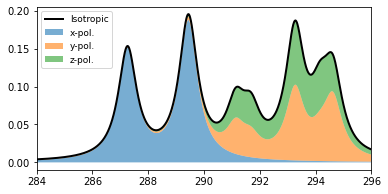

In [28]:
# Extract Cartesian components from ADC state (here skipping the prefactors)
adc_sX,adc_sY,adc_sZ = [],[],[]
adc_freq = adc_xas.excitation_energy
indx = 0
for w in adc_freq:
    tmp_tms = adc_xas.transition_dipole_moment[indx]
    adc_sX.append(w*tmp_tms[0]**2)
    adc_sY.append(w*tmp_tms[1]**2)
    adc_sZ.append(w*tmp_tms[2]**2)
    indx += 1

plt.figure(figsize=(6,3))
# Broadened spectra for each component
xmin,xmax = 284,296
x,y   = au2ev*adc_freq, adc_sX
xX,yX = lorentzian(x,y,xmin,xmax,0.01,0.8)
x,y   = au2ev*adc_freq, adc_sY
xY,yY = lorentzian(x,y,xmin,xmax,0.01,0.8)
x,y   = au2ev*adc_freq, adc_sZ
xZ,yZ = lorentzian(x,y,xmin,xmax,0.01,0.8)
# Plot it
plt.plot(xX,yX+yY+yZ,'k-',linewidth=2)
plt.fill_between(xX, 0, yX,alpha=0.6)
plt.fill_between(xX, yX, yX+yY,alpha=0.6)
plt.fill_between(xX, yX+yY, yX+yY+yZ,alpha=0.6)

plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'),fontsize=9)
plt.xlim((xmin,xmax))
plt.show()

And for CPP-DFT:

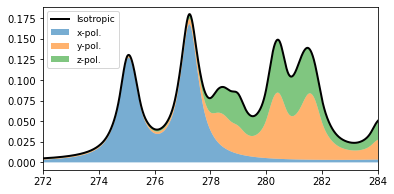

In [29]:
plt.figure(figsize=(6,3))
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
yX = interp1d(au2ev*freqs, sX, kind='cubic')
yY = interp1d(au2ev*freqs, sY, kind='cubic')
yZ = interp1d(au2ev*freqs, sZ, kind='cubic')
plt.plot(x,yX(x)+yY(x)+yZ(x),'k-',linewidth=2)
plt.fill_between(x, 0, yX(x), alpha=0.6)
plt.fill_between(x, yX(x), yX(x)+yY(x), alpha=0.6)
plt.fill_between(x, yX(x)+yY(x), yX(x)+yY(x)+yZ(x), alpha=0.6)
plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'),fontsize=9)
plt.xlim((272,284))
plt.show()

We see that the first two transitions are out-of-plane, being $\pi^{\ast}$.

Using a larger basis set of aug-cc-pCVT/cc-pVTZ and comparing to experiment, we obtain:


```{figure} ../img/xray/vinyl_decomp.svg
---
name: vinyl_decomp
---
ADC and TDDFT, atomic and polarization
```

```{note}
Fix this.
```

Looks pretty good - compares well. Maybe improves with CAM-B3LYP (or evem CAM100%-B3LYP), so could potentially change that further down the line.

## Visualization

```{note}
Could add, e.g.,

- Electron/hole densities

- Attachment/detachment densities

    - Compare to electron/hole - relaxation

- NTO:s?

- MOs?
```

## Descriptors

```{note}
Could add, e.g.,

- Electron/hole sizes etc

- Attachment/detachment sizes etc

- v2, R, ...
```